In [1]:
from sklearn import preprocessing, model_selection
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from numpy import genfromtxt

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

## Chooses the best hyperparameter configuration for each experiment

In this stage we will evaluate based on the defined metrics, which combination of hyperparameters had the best performance for each experiment

In [2]:
experiments = [dI for dI in os.listdir('../experiments') if os.path.isdir(os.path.join('../experiments',dI))]

best_models = []
for experiment in experiments:
    training_metrics = pd.read_csv('../experiments/' + experiment + '/training_metrics.csv')
    training_metrics = training_metrics.sort_values(['acc', 'precision', 'recall'], ascending=[False, False, False])
    best_model = training_metrics.iloc[0]
    best_model["experiment"] = experiment
    
    best_models.append(best_model)
    
best_models = pd.DataFrame(best_models).reset_index().drop(columns=['index'])
#best_models = best_models[['experiment', 'units', 'learning_rate', 'momentum', 'decay', 'activation_function', 'acc', 'loss', 'mae', 'mse', 'precision', 'recall', 'fs_score']] 
best_models = best_models.sort_values(['experiment'], ascending=True)
best_models

/Users/gcarvs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/gcarvs/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


,model_name,units,learning_rate,momentum,decay,activation_function,acc,loss,mae,mse,precision,recall,fs_score,experiment
2,model_262,75,0.0100,0.0100,0.0100,relu,0.578577,0.686320,0.5,0.262988,0.579032,0.563579,0.571201,mean_body
4,model_472,35,0.0100,0.0001,0.0001,relu,0.558249,0.717674,0.5,0.275367,0.549315,0.629513,0.586686,mean_title
5,model_448,35,0.0100,0.0100,0.0001,relu,0.541830,0.704175,0.5,0.262183,0.550495,0.436421,0.486865,mean_title_subtitle
1,model_345,75,0.0001,0.1000,0.1000,relu,0.548084,0.895111,0.5,0.329349,0.547812,0.530612,0.539075,pmean_body
0,model_536,35,0.0001,0.1000,0.0001,relu,0.556685,0.809226,0.5,0.314087,0.549858,0.605965,0.576550,pmean_title
3,model_224,75,0.1000,0.0010,0.0001,relu,0.542611,0.736829,0.5,0.284417,0.548327,0.463108,0.502128,pmean_title_subtitle


In [3]:
# formatted_best_models = best_models

# best_models_params = pd.DataFrame()
# best_models_params["experiment"] = best_models["experiment"]
# best_models_params["units"] = best_models["units"]
# best_models_params["learning_rate"] = best_models["learning_rate"]
# best_models_params["momentum"] = best_models["momentum"]
# best_models_params["decay"] = best_models["decay"]
# best_models_params["activation_function"] = best_models["activation_function"]

# best_models_results = pd.DataFrame()
# best_models_results["experiment"] = best_models["experiment"]
# best_models_results["acc"] = best_models["acc"] * 100
# best_models_results["precision"] = best_models["precision"] * 100
# best_models_results["recall"] = best_models["recall"] * 100
# best_models_results["fs_score"] = best_models["fs_score"] * 100
# best_models_results = formatted_best_models.round(2)

# best_models_params.to_csv("../data-analysis/best_models_params.csv", index= False, encoding='utf-8')
# best_models_results.to_csv("../data-analysis/best_models_results.csv", index= False, encoding='utf-8')

## Plots the Precision-Recall curve of the best models

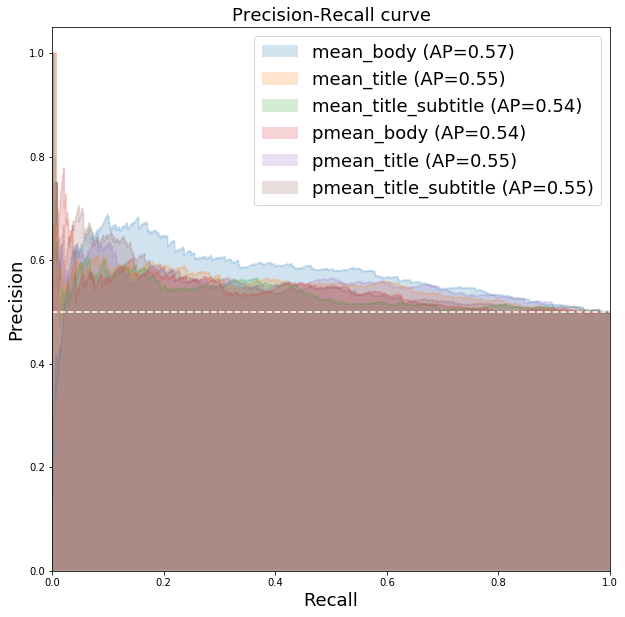

In [21]:
for index, model in best_models.iterrows(): 
    true_y = genfromtxt('../experiments/'+ model["experiment"] +'/test_y.csv', delimiter=',')
    output_probabilities = genfromtxt('../experiments/'+ model["experiment"] +'/trained_models/' + model["model_name"] + '/test_output_probabilities.csv', delimiter=',')

    probas_pred = output_probabilities[...,1]

    average_precision = average_precision_score(true_y, probas_pred)
    precision, recall, _ = precision_recall_curve(true_y, probas_pred)

    plt.step(recall, precision, alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, 
             label=model["experiment"] +' (AP={0:0.2f})'.format(average_precision))
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve', fontsize=18)
plt.plot([0, 1], [0.5, 0.5], color='white', linestyle='--')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.legend(loc='upper right', prop={'size': 18})
plt.savefig('../data-analysis/precision_recall_curve.png', dpi=300)
plt.show()

## Plots the ROC Curve of the models

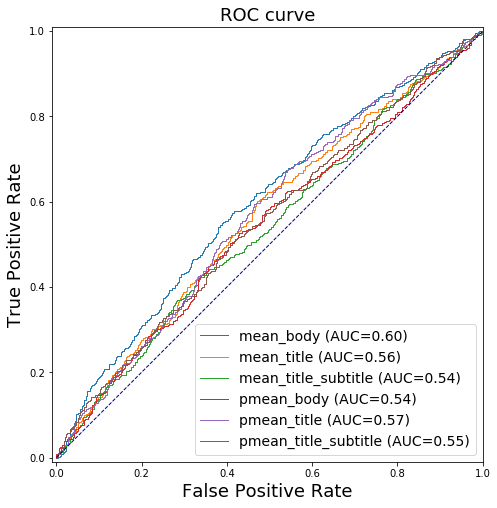

In [9]:
for index, model in best_models.iterrows(): 
    true_y = genfromtxt('../experiments/'+ model["experiment"] +'/test_y.csv', delimiter=',')
    output_probabilities = genfromtxt('../experiments/'+ model["experiment"] +'/trained_models/' + model["model_name"] + '/test_output_probabilities.csv', delimiter=',')
    
    probas_pred = output_probabilities[...,1]
    
    fpr_rf, tpr_rf, _ = roc_curve(true_y, probas_pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    plt.plot(fpr_rf, tpr_rf, lw=1, label='{} (AUC={:0.2f})'.format(model['experiment'],roc_auc_rf))
    #plt.plot(fpr_rf, tpr_rf, lw=1)

plt.title('ROC curve', fontsize=18)
plt.legend(loc='lower right', prop={'size': 14})
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)


plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

plt.axes().set_aspect('equal')
plt.savefig('../data-analysis/roc_curve.png', dpi=300)
plt.show()